In [1]:
import numpy as np 
import pandas as pd 
from datetime import datetime
import math
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as ex
import plotly.graph_objects as go
import plotly.offline as pyo
import torch
plt.rcParams['axes.unicode_minus'] = False
sns.set(font='Microsoft YaHei',font_scale=1.2)

In [2]:
country_covid = ['China', 'USA', 'UK']
#做了三个国家的，对策不同，预估模型结果也不太一样

In [3]:
# Define Model
def SIRD(St,It,Rt,Dt,beta,gamma,alpha,k):#k是vaccine影响因子
    N = St + It + Rt + Dt
    S_t1 = St - St * beta * It - k * N
    I_t1 = It + St * beta * It - gamma * It - alpha*It#感染患者的不治死亡率用alpha表示
    R_t1 = Rt + gamma * It + k * N
    D_t1 = Dt + alpha*It
    return S_t1, I_t1, R_t1, D_t1

In [4]:
class Feedforward(torch.nn.Module):#FNN前馈神经网络，反向传播法训练神经网络
    def __init__(self, is_debug = True):
        super(Feedforward, self).__init__()
        self.is_debug = is_debug
        # Initial Value：This is important
        self.beta = torch.nn.Parameter(torch.tensor(0.002))
        self.beta.requires_grad = True
        self.gamma = torch.nn.Parameter(torch.tensor(0.001))
        self.gamma.requires_grad = True
        self.alpha = torch.nn.Parameter(torch.tensor(0.001))
        self.alpha.requires_grad = True
        # Based on the slope of the curve in last section
        self.k = torch.nn.Parameter(torch.tensor(0.0001))
        self.k.requires_grad = True
    def forward(self,data):
        St,It,Rt,Dt = data
        S_t1 = St - self.beta * It - self.k * St
        I_t1 = It + self.beta * It - self.gamma * It - self.alpha*It-self.k * It
        R_t1 = Rt + self.gamma * It + self.k * St+self.k * It
        D_t1 = Dt + self.alpha*It
        if self.is_debug:
            print(self.beta,self.gamma,self.k,self.alpha)
        return S_t1, I_t1, R_t1,D_t1

model = Feedforward(is_debug=False)
# This is discarded later and replaced by handwritten loss function
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)

<ipython-input-5-186f1d55e370>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-5-186f1d55e370>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-5-186f1d55e370>:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-5-186f1d55

tensor([[2.9685e+08, 6.5141e+06, 2.4711e+07, 5.7648e+05],
        [2.9678e+08, 6.5014e+06, 2.4796e+07, 5.7721e+05],
        [2.9672e+08, 6.4978e+06, 2.4857e+07, 5.7754e+05],
        [2.9666e+08, 6.4716e+06, 2.4939e+07, 5.7804e+05],
        [2.9658e+08, 6.4799e+06, 2.5009e+07, 5.7887e+05],
        [2.9650e+08, 6.4847e+06, 2.5082e+07, 5.7983e+05],
        [2.9643e+08, 6.4785e+06, 2.5162e+07, 5.8075e+05],
        [2.9634e+08, 6.4862e+06, 2.5235e+07, 5.8165e+05],
        [2.9627e+08, 6.4830e+06, 2.5309e+07, 5.8242e+05],
        [2.9622e+08, 6.4787e+06, 2.5364e+07, 5.8273e+05],
        [2.9617e+08, 6.4493e+06, 2.5446e+07, 5.8323e+05],
        [2.9610e+08, 6.4459e+06, 2.5509e+07, 5.8412e+05],
        [2.9604e+08, 6.4312e+06, 2.5588e+07, 5.8505e+05],
        [2.9597e+08, 6.4338e+06, 2.5651e+07, 5.8598e+05],
        [2.9590e+08, 6.4411e+06, 2.5711e+07, 5.8680e+05],
        [2.9584e+08, 6.4533e+06, 2.5756e+07, 5.8755e+05],
        [2.9580e+08, 6.4532e+06, 2.5798e+07, 5.8785e+05],
        [2.957

No handles with labels found to put in legend.
findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans.


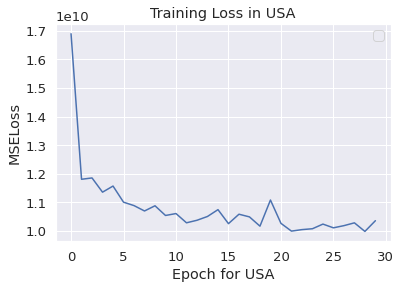

In [5]:
import torch
torch.set_default_tensor_type(torch.DoubleTensor)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, country_data, is_full_dataset=False):
        if is_full_dataset:
            self.data = torch.tensor(country_data, requires_grad=True)
        else:
            self.data = torch.tensor(country_data, requires_grad=True)
            self.data = self.data[:20]
            print(self.data)
    def __len__(self):
        return len(self.data)-1
    def __getitem__(self,index):
        return self.data[index],self.data[index+1]
# Get US data训练模型参数

covid = pd.read_csv('worldometer_coronavirus_daily_data.csv')
country_data = covid.loc[covid['country'] == 'USA']

country_data['Susceptible'] = 329227746-country_data['cumulative_total_cases']- country_data["cumulative_total_deaths"]#这个数字是总人口数量
country_data['Infected'] = country_data['active_cases'] 
country_data['Recovered'] = country_data['cumulative_total_cases'] - country_data['active_cases'] - country_data["cumulative_total_deaths"]
country_data['Dead'] = country_data["cumulative_total_deaths"]#增添D维度描述累计死亡人数，由于和R是一个数量级的，所以减去会带来更准确的结果
country_data= country_data[['Susceptible','Infected','Recovered','Dead']]
# Starting from Jan13 2021 (when we have vaccination data for USA)
# country_data_US = country_data_US.tail(119)
# Use Recent Data when vaccination is more stable，把疫苗作为医疗手段的一种
country_data = country_data.tail(50)
country_data = country_data.values

# Initialize a dataset
Covid_dataset = Dataset(country_data)#适用于Torch的数据格式
dataloader = torch.utils.data.DataLoader(Covid_dataset, batch_size=1, shuffle=True, num_workers=0)
loss_log = []
#epoch 如何设置： 大小与数据集的多样化程度有关， 多样化程度越强， epoch 越大。
#一个epoch , 表示： 所有的数据送入网络中， 完成了一次前向计算 + 的过程。
for epoch in range(30):
    train_loss = 0
    for i, data in enumerate(dataloader):
        optimizer.zero_grad()
        x_train = data[0][0]
        y_train = data[1][0]
        # x_train = torch.squeeze(x_train)
        # y_train = torch.squeeze(y_train)
        # Forward pass
        s, i, r, d= model(x_train)
        # Compute Loss
        loss = (y_train[0]-s).pow(2) + (y_train[1] - i).pow(2) + (y_train[2] - r).pow(2) + (y_train[3] - d).pow(2)
        train_loss += loss.item()
        # Backward pass
        loss.backward()
        # print(loss.grad)
        # print(y_pred.grad)
        optimizer.step()
    loss_log.append(train_loss)
    #print('Epoch {}: train loss: {}'.format(epoch, train_loss))

torch.save(model.state_dict(),'./_SIR_parameter.pth')

# Plot loss
def plot_loss(epoch,log, country):
    plt.plot(epoch, log)
    plt.xlabel("Epoch for "+ country)
    plt.ylabel("MSELoss")
    plt.title("Training Loss in "+country)
    plt.legend()
    plt.show()

plot_loss(range(30),loss_log, "USA")

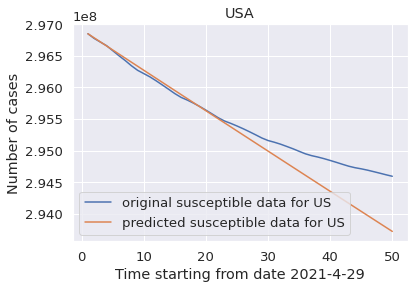

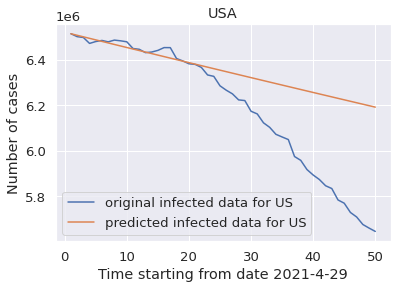

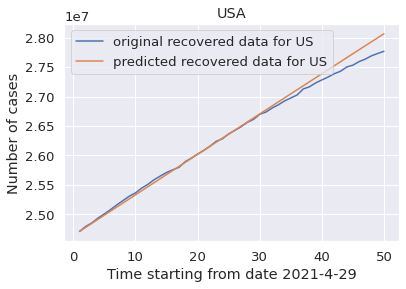

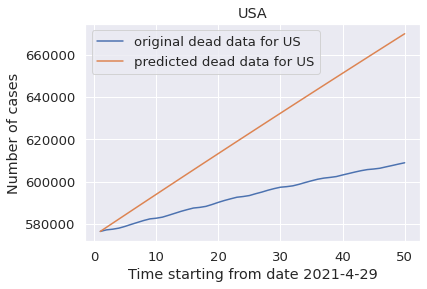

In [6]:
def plot_prediction(country_data, country, t, type_of_people, location):
    df = covid.loc[covid['country'] == location]
    date = df['date'].tail(t)#预测最后t天的疫情情况
    date = date.values
    day = date[0]
    x = range(1, len(country_data)+1)
    
    input_data = torch.tensor(country_data[0])
    model = Feedforward(is_debug=False)
    model.load_state_dict(torch.load('_SIR_parameter.pth'))
    model.eval()
    
    prediction = []
    s, i, r, d = input_data
    convert = [s.item(), i.item(), r.item(),d.item()]
    prediction.append(convert)
    
    for i in range(len(country_data)-1):
        input_data = model(input_data)
        s, i, r ,d = input_data
        convert = [s.item(), i.item(), r.item(),d.item()]
        prediction.append(convert)
    
    prediction = np.array(prediction)
    
    if type_of_people == 'S':
        plt.plot(x, country_data[:,0], label='original susceptible data for '+country)
        plt.plot(x, prediction[:,0], label='predicted susceptible data for '+country)
    if type_of_people == 'I':
        plt.plot(x, country_data[:,1], label='original infected data for '+country)
        plt.plot(x, prediction[:,1], label='predicted infected data for '+country)
    if type_of_people == 'R':
        plt.plot(x, country_data[:,2], label='original recovered data for '+country)
        plt.plot(x, prediction[:,2], label='predicted recovered data for '+country)
    if type_of_people == 'D':
        plt.plot(x, country_data[:,3], label='original dead data for '+country)
        plt.plot(x, prediction[:,3], label='predicted dead data for '+country)

    plt.xlabel("Time starting from date "+day)
    plt.ylabel("Number of cases")
    plt.title("USA")
    plt.legend()
    plt.show()
plot_prediction(country_data, 'US', 30, 'S', 'USA')
plot_prediction(country_data, 'US', 30, 'I', 'USA')
plot_prediction(country_data, 'US', 30, 'R', 'USA')
plot_prediction(country_data, 'US', 30, 'D', 'USA')

<ipython-input-7-6865fcc773b8>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-7-6865fcc773b8>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-7-6865fcc773b8>:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-7-6865fcc7

tensor([[1.4117e+09, 3.2400e+02, 8.5682e+04, 4.6360e+03],
        [1.4117e+09, 3.2800e+02, 8.5691e+04, 4.6360e+03],
        [1.4117e+09, 3.2500e+02, 8.5710e+04, 4.6360e+03],
        [1.4117e+09, 3.2500e+02, 8.5725e+04, 4.6360e+03],
        [1.4117e+09, 3.2300e+02, 8.5738e+04, 4.6360e+03],
        [1.4117e+09, 3.2500e+02, 8.5753e+04, 4.6360e+03],
        [1.4117e+09, 3.1900e+02, 8.5766e+04, 4.6360e+03],
        [1.4117e+09, 3.1400e+02, 8.5776e+04, 4.6360e+03],
        [1.4117e+09, 3.0800e+02, 8.5795e+04, 4.6360e+03],
        [1.4117e+09, 3.0000e+02, 8.5810e+04, 4.6360e+03],
        [1.4117e+09, 3.0000e+02, 8.5822e+04, 4.6360e+03],
        [1.4117e+09, 2.9800e+02, 8.5835e+04, 4.6360e+03],
        [1.4117e+09, 3.0200e+02, 8.5845e+04, 4.6360e+03],
        [1.4117e+09, 3.0200e+02, 8.5861e+04, 4.6360e+03],
        [1.4117e+09, 2.9100e+02, 8.5881e+04, 4.6360e+03],
        [1.4117e+09, 2.8500e+02, 8.5894e+04, 4.6360e+03],
        [1.4117e+09, 2.7900e+02, 8.5914e+04, 4.6360e+03],
        [1.411

No handles with labels found to put in legend.


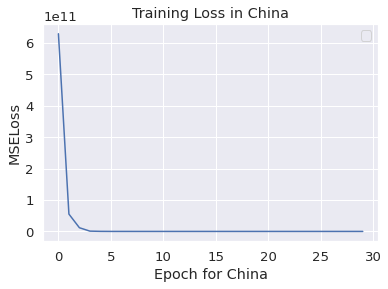

In [7]:
import torch
torch.set_default_tensor_type(torch.DoubleTensor)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, country_data, is_full_dataset=False):
        if is_full_dataset:
            self.data = torch.tensor(country_data, requires_grad=True)
        else:
            self.data = torch.tensor(country_data, requires_grad=True)
            self.data = self.data[:20]
            print(self.data)
    def __len__(self):
        return len(self.data)-1
    def __getitem__(self,index):
        return self.data[index],self.data[index+1]
# Get US data训练模型参数

covid = pd.read_csv('worldometer_coronavirus_daily_data.csv')
country_data = covid.loc[covid['country'] == 'China']

country_data['Susceptible'] = 1411780000-country_data['cumulative_total_cases']- country_data["cumulative_total_deaths"]#这个数字是总人口数量，2020第七次人口普查结果
country_data['Infected'] = country_data['active_cases'] 
country_data['Recovered'] = country_data['cumulative_total_cases'] - country_data['active_cases'] - country_data["cumulative_total_deaths"]
country_data['Dead'] = country_data["cumulative_total_deaths"]#增添D维度描述累计死亡人数，由于和R是一个数量级的，所以减去会带来更准确的结果
country_data= country_data[['Susceptible','Infected','Recovered','Dead']]
# Starting from Jan13 2021 (when we have vaccination data for USA)
# country_data_US = country_data_US.tail(119)
# Use Recent Data when vaccination is more stable，把疫苗作为医疗手段的一种
country_data = country_data.tail(30)
country_data = country_data.values

# Initialize a dataset
Covid_dataset = Dataset(country_data)#适用于Torch的数据格式
dataloader = torch.utils.data.DataLoader(Covid_dataset, batch_size=1, shuffle=True, num_workers=0)
loss_log = []
#epoch 如何设置： 大小与数据集的多样化程度有关， 多样化程度越强， epoch 越大。
#一个epoch , 表示： 所有的数据送入网络中， 完成了一次前向计算 + 反向传播的过程。
for epoch in range(30):
    train_loss = 0
    for i, data in enumerate(dataloader):
        optimizer.zero_grad()
        x_train = data[0][0]
        y_train = data[1][0]
        # x_train = torch.squeeze(x_train)
        # y_train = torch.squeeze(y_train)
        # Forward pass
        s, i, r, d= model(x_train)
        # Compute Loss
        loss = (y_train[0]-s).pow(2) + (y_train[1] - i).pow(2) + (y_train[2] - r).pow(2) + (y_train[3] - d).pow(2)
        train_loss += loss.item()
        # Backward pass
        loss.backward()
        # print(loss.grad)
        # print(y_pred.grad)
        optimizer.step()
    loss_log.append(train_loss)
    #print('Epoch {}: train loss: {}'.format(epoch, train_loss))

torch.save(model.state_dict(),'./_SIR_parameter.pth')

# Plot loss
def plot_loss(epoch,log, country):
    plt.plot(epoch, log)
    plt.xlabel("Epoch for "+ country)
    plt.ylabel("MSELoss")
    plt.title("Training Loss in "+country)
    plt.legend()
    plt.show()

plot_loss(range(30),loss_log, "China")

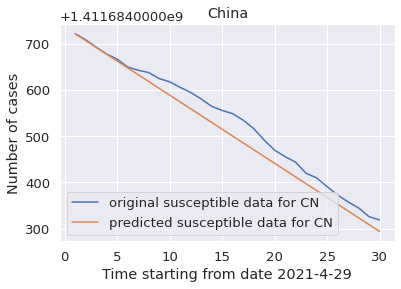

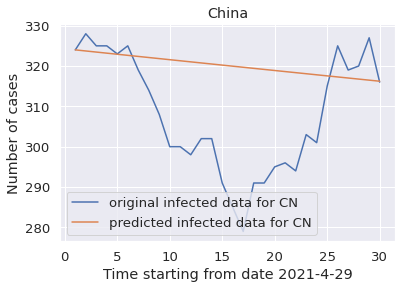

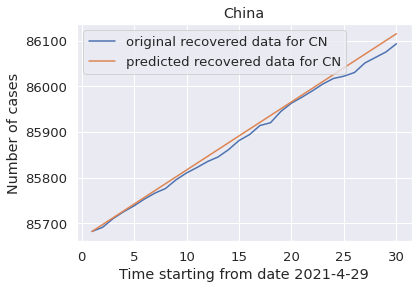

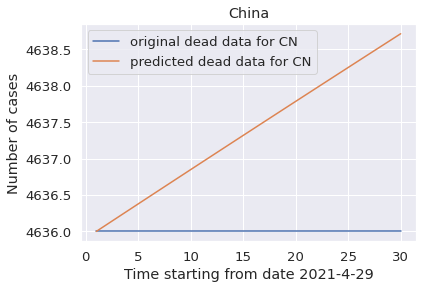

In [8]:
def plot_prediction(country_data, country, t, type_of_people, location):
    df = covid.loc[covid['country'] == location]
    date = df['date'].tail(t)#预测最后t天的疫情情况
    date = date.values
    day = date[0]
    x = range(1, len(country_data)+1)
    
    input_data = torch.tensor(country_data[0])
    model = Feedforward(is_debug=False)
    model.load_state_dict(torch.load('_SIR_parameter.pth'))
    model.eval()
    
    prediction = []
    s, i, r, d = input_data
    convert = [s.item(), i.item(), r.item(),d.item()]
    prediction.append(convert)
    
    for i in range(len(country_data)-1):
        input_data = model(input_data)
        s, i, r ,d = input_data
        convert = [s.item(), i.item(), r.item(),d.item()]
        prediction.append(convert)
    
    prediction = np.array(prediction)
    
    if type_of_people == 'S':
        plt.plot(x, country_data[:,0], label='original susceptible data for '+country)
        plt.plot(x, prediction[:,0], label='predicted susceptible data for '+country)
    if type_of_people == 'I':
        plt.plot(x, country_data[:,1], label='original infected data for '+country)
        plt.plot(x, prediction[:,1], label='predicted infected data for '+country)
    if type_of_people == 'R':
        plt.plot(x, country_data[:,2], label='original recovered data for '+country)
        plt.plot(x, prediction[:,2], label='predicted recovered data for '+country)
    if type_of_people == 'D':
        plt.plot(x, country_data[:,3], label='original dead data for '+country)
        plt.plot(x, prediction[:,3], label='predicted dead data for '+country)

    plt.xlabel("Time starting from date "+day)
    plt.ylabel("Number of cases")
    plt.title('China')
    plt.legend()
    plt.show()
plot_prediction(country_data, 'CN', 30, 'S', 'China')
plot_prediction(country_data, 'CN', 30, 'I', 'China')
plot_prediction(country_data, 'CN', 30, 'R', 'China')
plot_prediction(country_data, 'CN', 30, 'D', 'China')